# Protein Secondary Structure Prediction with Recurrent Neural Networks And GRUs

# Importing Required Libraries

In [2]:
%pip install -r requirements.txt

Processing c:\b\abs_98xvdek9qa\croot\aext-assistant_1734644152369\work (from -r requirements.txt (line 3))
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\b\\abs_98xvdek9qa\\croot\\aext-assistant_1734644152369\\work'



In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.utils.data as utils
from torch.nn.utils.rnn import pad_sequence ,pack_padded_sequence,pad_packed_sequence

import numpy as np
import random
import os
import math
import pickle
import time
import tqdm

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

### Set Random Number Initializers for Repeatability

In [5]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [54]:
#IMPORTANT HYPERPARAMETERS
BATCH_SIZE = 32 # Values you can try out: 64, 128, 1
LEARNING_RATE = 0.001 
EPOCHS = 100
DROPOUT = 0.2
HIDDEN_SIZE = 128
EMBEDDING_SIZE = 128
NUM_LAYERS =1 # Number of layers in the RNN
PATIENCE = 10 # Early stopping patience
MIN_DELTA = 0.001 # Minimum change in validation acc to qualify as an improvement

Our Targets are : 

'H' : α-helix , 3-helix , π-helix

'E' : β-strand , β-bridge

'C' : Loops and irregular elements , Turn , Bend

Residue names are alphabets corresponding to different amino acids ie "A" --> Alanine

In [6]:
target_names=["H","E","C"]
residue_names = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq']

#### Set device for the model to run on.
GPU is preferred as RNNs take longer to train.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)
cpu = torch.device('cpu')

cuda


### Preprocessing the data
First, we need to define Dataset class in pytorch which must have 3 functions : __init__(), __getitem__(), __len__().

Now,our protein sequences are of different length. But, the batch we load will have fixed size. Hence, we take this size to be the size of the longest sequence in the batch and pad the shorter sequences.

In [8]:
def load_from_pkl(path):
    with open(path, 'rb') as f:
        var = pickle.load(f)
    return var

# class to index loaded dataset
class Dataset(data.Dataset):
    def __init__(self, path_to_pkl):
        self.data = load_from_pkl(path_to_pkl)
        self.ids = list(self.data.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id = self.ids[index]
        dict = self.data[id]
        seq = dict["sequence"]
        pssm = dict["pssm"]
        length = len(seq)
        
        secstr = dict["secstr"]
        secstr_q3 = dict["secstr_q3"]

        return id,seq,pssm,length,secstr,secstr_q3
    
# Helper Function to pad a batch of protein sequences.
def pad_batch(DataLoaderBatch):
    """
    DataLoaderBatch should be a list of (sequence, target, length) tuples...
    Returns a padded tensor of sequences sorted from longest to shortest, 
    """
    batch_size = len(DataLoaderBatch)
    batch_split = list(zip(*DataLoaderBatch))

    ids, seqs, pssms, lengths, secstrs, secstrs_q3 = batch_split[0], batch_split[1], batch_split[2] ,batch_split[3], batch_split[4], batch_split[5]
    max_length = max(lengths)

    padded_seqs = np.zeros((max_length, batch_size))
    padded_pssms = np.zeros((max_length,batch_size,22))
    padded_secstrs = np.ones((max_length,batch_size))*30
    padded_secstrs_q3 = np.ones((max_length,batch_size))*30
    
    for i, l in enumerate(lengths):
        padded_seqs[:l,i] = seqs[i][:l] + 1
        padded_pssms[:l,i,:] = pssms[i][:l][:]
        padded_secstrs[:l,i] = secstrs[i][:l]
        padded_secstrs_q3[:l,i] = secstrs_q3[i][:l]
    return torch.tensor(padded_seqs).type(torch.LongTensor), torch.tensor(padded_pssms).type(torch.float), torch.tensor(lengths), torch.tensor(padded_secstrs).type(torch.LongTensor), torch.tensor(padded_secstrs_q3).type(torch.LongTensor)

In [10]:
def load_from_pkl(path):
    with open(path, 'rb') as f:
        var = pickle.load(f)
    return var
var = load_from_pkl("./Datasets/Datasets/train.pkl")

In [11]:
len(var)
num_0=0
num_1=0
num_2=0
max_len=0
for i in (var):
    if len(var[i]["secstr_q3"]) > max_len:
        max_len = len(var[i]["secstr_q3"])
    for j in range(len(var[i]["secstr_q3"])):
        if var[i]["secstr_q3"][j] == 0:
            num_0+=1
        elif var[i]["secstr_q3"][j] == 1:
            num_1+=1
        elif var[i]["secstr_q3"][j] == 2:
            num_2+=1
print("Number of H: ",num_0)
print("Number of E: ",num_1)
print("Number of C: ",num_2)
print("Max Length: ",max_len)
print(var[0]["sequence"])

Number of H:  393620
Number of E:  247261
Number of C:  500345
Max Length:  696
[10  2  1  7 11 12 12 14 14 12 16 13 16 16 16  4  1 14  4  4  2 16 11  1
 19  8  8 15 17 15  3  7 15  4 19 15 16  2 15  4  1  4  1 13 14 18  8 11
  4  6  2  6 11  1  1 16 16  3 15  1 11 11]


## Label Distribution

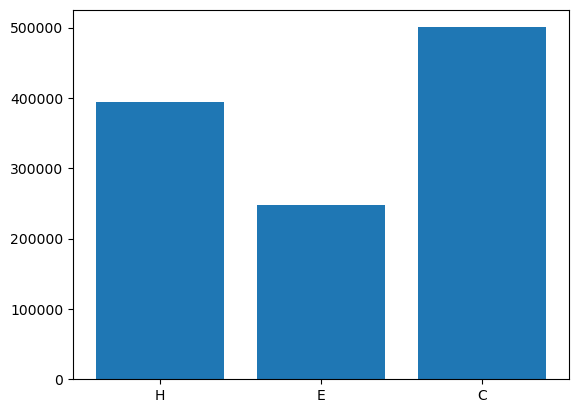

In [12]:
plt.bar(range(3), [num_0, num_1, num_2], tick_label=target_names)
plt.show()

### Load data in Pytorch Dataloaders

In [23]:
# Load train, test and validation data
train = Dataset("./Datasets/Datasets/train.pkl")
val = Dataset("./Datasets/Datasets/val.pkl")
test = Dataset("./Datasets/Datasets/test.pkl")

# Data Generators for each set.
train_gen = data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_batch)
val_gen = data.DataLoader(val, batch_size=BATCH_SIZE,shuffle=False,collate_fn=pad_batch)
test_gen = data.DataLoader(test, batch_size=BATCH_SIZE,shuffle=False,collate_fn=pad_batch)

In [34]:
train_iter = next(iter(train_gen))
print("Train Batch Shape: ", train_iter[0].shape, train_iter[1].shape, train_iter[2].shape, train_iter[3].shape, train_iter[4].shape)

Train Batch Shape:  torch.Size([512, 32]) torch.Size([512, 32, 22]) torch.Size([32]) torch.Size([512, 32]) torch.Size([512, 32])


## Defining different layers of our model

### Dense Layer

This is a simple NN fully connected layer with dropout and layernorm.

In [ ]:
# Dense Layer
class Dense(nn.Module):
    def __init__(self,input_dim,output_dim,dropout = DROPOUT,normalization = True,activation = F.relu):
        super(Dense, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_rate = dropout
        self.activation = activation
        self.n_state = normalization        
        self.linear = nn.Linear(self.input_dim,self.output_dim)
        self.layernorm = nn.LayerNorm(self.output_dim)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        if self.n_state:
            x = self.layernorm(x)
        x = self.dropout(x)
        return x

A Unidirectional RNN Layer.

In [26]:
# Unidirectional RNN
class rnn_unidirectional(nn.Module):
    def __init__(self,inp,out,dropout=DROPOUT,activation=F.relu):
        super(rnn_unidirectional,self).__init__()
        self.rnn = nn.RNN(inp,out,bidirectional=False,num_layers=NUM_LAYERS)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False)
        out,_ = self.rnn(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

A Bidirectional RNN Layer

In [27]:
# Bidirectional RNN
class rnn_bidirectional(nn.Module):
    def __init__(self,inp,out,dropout=DROPOUT,activation=F.relu):
        super(rnn_bidirectional,self).__init__()
        self.rnn = nn.RNN(inp,out,bidirectional=True,num_layers=NUM_LAYERS)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(2*out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False)
        out,_ = self.rnn(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

A bidirectional GRU layer.

In [ ]:
# Bidirectional GRU
class gru_bidirectional(nn.Module):
    def __init__(self,inp,out,dropout=0.1,activation=F.relu):
        super(gru_bidirectional,self).__init__()
        self.gru = nn.GRU(inp,out,bidirectional=True,num_layers=2)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(2*out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False) #as we padded our sequences while batching,this undos the padding
        out,_ = self.gru(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

## Defining model architectures

We define 3 different models, with a RNN(unidirectional), RNN(bidirectional) and GRU(Bidirectional) layer respectively,followed by a fully connected linear layer.

In each model,we have added an embedding layer to convert one hot embedding of atom to a higher dimensional embedding. Ths is is because pssm is in floats, and hence it would be better if atom type information was also provided to model in floating point representation, also this makes the representation less sparse and the model can learn relationships between different atom types

In [86]:
class RNN_unidir_model(nn.Module):
    def __init__(self,embedding_count=23,embedding_dim=50,output_dim=3):
        super(RNN_unidir_model, self).__init__()
        self.embedding = nn.Embedding(embedding_count,embedding_dim=embedding_dim,padding_idx=0)
        
        self.layernorm = nn.LayerNorm(22+embedding_dim)
        
        #RNN layer
        self.rnn_1 = rnn_unidirectional(22+embedding_dim,128,0.2)
        
        #Output layers
        self.linear_1 = Dense(128,64)
        self.Q3 = Dense(64,output_dim,dropout=0)
        
    def forward(self,x,pssm,x_lengths):
        emb = self.embedding(x) # Convert sequence of indices to embeddings
        emb = torch.cat([emb,pssm],dim=-1) # Concatenate PSSM features with embeddings

        x_normalized = self.layernorm(emb)
        
        gru = self.rnn_1(x_normalized,x_lengths)
        
        out = self.linear_1(gru)
        Q3 = self.Q3(out)
        return Q3

In [87]:
class RNN_bidirec_model(nn.Module):
    def __init__(self,embedding_count=23,embedding_dim=5050,output_dim=3):
        super(RNN_bidirec_model, self).__init__()
        self.embedding = nn.Embedding(embedding_count,embedding_dim=embedding_dim,padding_idx=0)
        
        self.layernorm = nn.LayerNorm(22+embedding_dim)
        
        #RNN bidirectional layer
        self.rnn_1 = rnn_bidirectional(22+embedding_dim,64,0.2)
        
        #Output layers
        self.linear_1 = Dense(128,64)
        self.Q3 = Dense(64,output_dim,dropout=0)
        
    def forward(self,x,pssm,x_lengths):
        emb = self.embedding(x) # Convert sequence of indices to embeddings
        emb = torch.cat([emb,pssm],dim=-1) # Concatenate PSSM features with embeddings

        x_normalized = self.layernorm(emb)
        
        gru = self.rnn_1(x_normalized,x_lengths)
        
        out = self.linear_1(gru)
        Q3 = self.Q3(out)
        return Q3

In [88]:
class GRU_bidirec_model(nn.Module):
    def __init__(self,embedding_count=23,embedding_dim=50,output_dim=3):
        super(GRU_bidirec_model, self).__init__()
        self.embedding = nn.Embedding(embedding_count,embedding_dim=embedding_dim,padding_idx=0)
        
        self.layernorm = nn.LayerNorm(22+embedding_dim)
        
        #GRU
        self.gru_1 = gru_bidirectional(22+embedding_dim,64,0.2)
        
        #Output layers
        self.linear_1 = Dense(128,64)
        self.Q3 = Dense(64,output_dim,dropout=0)
        
    def forward(self,x,pssm,x_lengths):
        emb = self.embedding(x)
        emb = torch.cat([emb,pssm],dim=-1)

        x_normalized = self.layernorm(emb)
        
        gru = self.gru_1(x_normalized,x_lengths)
        
        out = self.linear_1(gru)
        Q3 = self.Q3(out)
        return Q3

# Training Models

In [56]:
os.makedirs("saved_models", exist_ok=True) # Create directory to save models
results_dir = {} # Dictionary to store results of different models

### Train Epoch helper Function

In [89]:
def train_epoch(generator,network,optimizer,criterion,task="Q3"):
    #     Set the network in to train mode
    #     Enables dropout. 
    network.train()
    total_loss = 0.
    start_time = time.time() # Track training time.
    prediction = [] #output prediction of model - vector of probabilities for each class
    g_t = [] # ground truth labels for each sequence - actual secondary structure
    for seq,pssm,length,q8,q3 in tqdm.tqdm(generator,desc="Training"):
        batch_size = seq.shape[1]  # Get the batch size from the shape of the sequence tensor.
        optimizer.zero_grad()  # Make all gradients at each trainable parameter zero.
        output = network(seq.to(device),pssm.to(device),length.to(cpu)) # Perform a forward pass
        if task == "Q8":
            loss = criterion(output.view(-1,8).to(device),q8.view(-1).to(device))  #Compute the loss function
        else:
            loss = criterion(output.view(-1,3).to(device),q3.view(-1).to(device))
        loss.backward() # Perform back propagation 
        torch.nn.utils.clip_grad_norm_(network.parameters(), 0.5)  # Clip gradients to increase stability of training
        optimizer.step()  # Perform the optimization step.
        
        total_loss += loss.cpu().detach().numpy()
        
        # store all predictions to calculate accuracy at end of epoch
        for i in range(len(length)):
            prediction.append(output[0:length[i],i,:].cpu().detach().numpy())
            if task == "Q8":
                g_t.append(q8[0:length[i],i].cpu().detach().numpy())
            else:
                g_t.append(q3[0:length[i],i].cpu().detach().numpy())
    ave_loss = total_loss / len(generator)  # Average loss over the epoch
    predictions = np.argmax(np.concatenate(prediction,axis=0),axis=-1)
    g_ts = np.concatenate(g_t)
    
    # calculate accuracy
    acc = accuracy_score(predictions,g_ts) 
    end_time = time.time()
    return end_time-start_time , ave_loss, acc

### Evaluation Epoch Helper function

In [90]:
def evaluate(generator,network,criterion, print_acc_report=False,output_sample=False,task ="Q3"):
    
    with torch.no_grad(): # disable gradients as no optimization done during evaluation
        network.eval()  # set network to evaluation mode to disable dropouts
        total_loss = 0.
        start_time = time.time() # Track evaluation time
        prediction = []
        g_t = []   
        for seq,pssm,length,q8,q3 in tqdm.tqdm(generator,desc="Evaluating"):
            batch_size = seq.shape[1]  # Get the batch size from the shape of the sequence tensor.
            #    Get predictions
            output = network(seq.to(device),pssm.to(device),length.to(cpu))
            
            #    Calculate loss for analysis
            if task == "Q8":
                loss = criterion(output.view(-1,8).to(device),q8.view(-1).to(device))  #Compute the loss function
            else:
                loss = criterion(output.view(-1,3).to(device),q3.view(-1).to(device))        
            total_loss += loss.cpu().detach().numpy()
            for i in range(len(length)):
                prediction.append(output[0:length[i],i,:].cpu().detach().numpy())
                if task == "Q8":
                    g_t.append(q8[0:length[i],i].cpu().detach().numpy())
                else:
                    g_t.append(q3[0:length[i],i].cpu().detach().numpy())
        ave_loss = total_loss / len(generator)
        #   calculate  accuracy for analysis       
        predictions = np.argmax(np.concatenate(prediction,axis=0),axis=-1)
        g_ts = np.concatenate(g_t)
        acc = accuracy_score(predictions,g_ts) 
        end_time = time.time()
        if print_acc_report:
            print (classification_report(g_ts,predictions,target_names=target_names))
    return end_time-start_time, ave_loss, acc

### Train model function

In [98]:
def train_model(network,train_gen,val_gen,optimizer,criterion,num_epochs=100,
                patience=10, min_delta=0.001, save_best_model=True, model_save_path="best_model.pth",task="Q3"):
    """Train model for num_epochs epochs, with early stopping based on validation accuracy."""
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_epoch = 0
    for i in range(num_epochs):
        #     Train epoch
        run_time,train_loss,train_acc = train_epoch(train_gen,network,optimizer,criterion,task=task)
        
        #     Validation step
        _,val_loss,val_acc = evaluate(val_gen,network,criterion,task=task)
        
        #     Track performance of network during training
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Early stopping logic based on validation accuracy
        if val_acc > best_val_acc + min_delta:
            # Significant improvement found
            best_val_acc = val_acc
            epochs_without_improvement = 0
            best_epoch = i + 1
            
            # Save the best model
            if save_best_model:
                torch.save(network.state_dict(), model_save_path)
                
        else:
            # No significant improvement
            epochs_without_improvement += 1
            
            if epochs_without_improvement >= patience:
                print(f"\n Early stopping triggered after {i + 1} epochs!")
                print(f"Best model was at epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
                break
        
        #     Print performance metrics
        print ("Epoch : "+str(i)+", Train_loss : "+str(train_loss)+", Train_acc : "+str(train_acc)+", Val_acc : "+ str(val_acc))
    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

## Plotting Training Results

In [66]:
def plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history):
    """
    Plot training results showing loss and accuracy vs epoch.
    
    Args:
        train_acc_history: List of training accuracies per epoch
        val_acc_history: List of validation accuracies per epoch  
        train_loss_history: List of training losses per epoch
        val_loss_history: List of validation losses per epoch
    """
    epochs = range(1, len(train_acc_history) + 1)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracies
    axes[0].plot(epochs, train_acc_history, 'b-', label='Train Accuracy', marker='o', markersize=4)
    axes[0].plot(epochs, val_acc_history, 'r-', label='Validation Accuracy', marker='s', markersize=4)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Plot losses
    axes[1].plot(epochs, train_loss_history, 'b-', label='Train Loss', marker='o', markersize=4)
    axes[1].plot(epochs, val_loss_history, 'r-', label='Validation Loss', marker='s', markersize=4)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Evaluating Model

In [104]:
def evaluate_best_model(model_class, model_path, test_gen, criterion, device, task="Q3"):
    """
    Load the best model and evaluate it on test set with comprehensive metrics and plots.
    
    Args:
        model_class: The model class (e.g., RNN_unidir_model)
        model_path: Path to the saved best model weights
        test_gen: Test data generator
        criterion: Loss function
        device: Device to run evaluation on
        target_names: List of class names for confusion matrix
    """
    if task == "Q8":
        target_names = list(range(8))  # For Q8, target names are 0-7
    else:
        target_names = ["H", "E", "C"]
    
    # Load the best model
    if task == "Q8":
        model = model_class(output_dim=8).to(device)
    else:
        model = model_class(output_dim=3).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
  
    # Evaluate on test set
    with torch.no_grad():
        total_loss = 0.
        all_predictions = []
        all_targets = []
        
        for seq, pssm, length, q8, q3 in tqdm.tqdm(test_gen, desc="Evaluating on test set"):
            batch_size = seq.shape[1]
            
            # Get predictions
            output = model(seq.to(device), pssm.to(device), length.to('cpu'))
            
            # Calculate loss
            if task == "Q8":
                loss = criterion(output.view(-1, 8).to(device), q8.view(-1).to(device))
            else:
                loss = criterion(output.view(-1, 3).to(device), q3.view(-1).to(device))
            total_loss += loss.cpu().detach().numpy() / batch_size
            
            # Store predictions and targets for each sequence
            for i in range(len(length)):
                seq_predictions = output[0:length[i], i, :].cpu().detach().numpy()
                if task == "Q8":
                    seq_targets = q8[0:length[i], i].cpu().detach().numpy()
                else:
                    seq_targets = q3[0:length[i], i].cpu().detach().numpy()
                
                all_predictions.append(seq_predictions)
                all_targets.append(seq_targets)
        
        # Convert to flat arrays
        predictions_flat = np.argmax(np.concatenate(all_predictions, axis=0), axis=-1)
        targets_flat = np.concatenate(all_targets)
        
        # Calculate overall accuracy
        test_accuracy = accuracy_score(targets_flat, predictions_flat)
        avg_test_loss = total_loss / len(test_gen)
    
    # Print metrics
    print(f"\nTest Results:")
    print(f"  Test Loss:     {avg_test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # Create confusion matrix
    cm = confusion_matrix(targets_flat, predictions_flat)
    
    # Create plots
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names, ax=axes)
    axes.set_title('Confusion Matrix')
    axes.set_xlabel('Predicted')
    axes.set_ylabel('Actual')
 
    
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class metrics
    print(f"\nPer-Class Performance:")
    for i, class_name in enumerate(target_names):
        # True positives, false positives, false negatives
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        
        # Precision, Recall, F1-score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"  {class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    
    return {
        'test_accuracy': test_accuracy,
        'test_loss': avg_test_loss,
        'confusion_matrix': cm,
        'predictions': predictions_flat,
        'targets': targets_flat,
        'classification_report': classification_report(targets_flat, predictions_flat, target_names=target_names, output_dict=True,zero_division=0)
    }

### Train RNN Unidirectional Model

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
rnn_model = RNN_unidir_model().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(rnn_model.parameters(),lr=0.001)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    rnn_model, train_gen, val_gen, optimizer, criterion, num_epochs=EPOCHS,
    patience=PATIENCE, min_delta=MIN_DELTA, save_best_model=True, model_save_path="saved_models/best_rnn_model.pth"
)

cuda


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 63.83it/s]


Epoch : 0, Train_loss : 1.0487440137302175, Train_acc : 0.4640684667191249, Val_acc : 0.49780950835632


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 65.65it/s]


Epoch : 1, Train_loss : 0.990739518404007, Train_acc : 0.509001722708736, Val_acc : 0.5274217102060684


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 55.72it/s]


Epoch : 2, Train_loss : 0.9089315687908845, Train_acc : 0.5910713565936984, Val_acc : 0.6294012656173942


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 63.77it/s]


Epoch : 3, Train_loss : 0.8626646097968607, Train_acc : 0.6296474142720198, Val_acc : 0.6487708907999351


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 64.68it/s]


Epoch : 4, Train_loss : 0.8243685392772451, Train_acc : 0.6614001083045777, Val_acc : 0.680674995943534


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 60.10it/s]


Epoch : 5, Train_loss : 0.8000949386288138, Train_acc : 0.6723348399002477, Val_acc : 0.671101736167451


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 55.94it/s]


Epoch : 6, Train_loss : 0.790960389025071, Train_acc : 0.6759782900144231, Val_acc : 0.6876723998052896


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 61.02it/s]


Epoch : 7, Train_loss : 0.767399433781119, Train_acc : 0.688562125293325, Val_acc : 0.7016266428687328


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 54.46it/s]


Epoch : 8, Train_loss : 0.7557018672718722, Train_acc : 0.6918130151258384, Val_acc : 0.7009573259776083


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 60.17it/s]


Epoch : 9, Train_loss : 0.74600809952792, Train_acc : 0.6941780155727262, Val_acc : 0.7032289469414247


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 60.09it/s]


Epoch : 10, Train_loss : 0.7327158815720503, Train_acc : 0.702884441819587, Val_acc : 0.7145667694304721


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 63.49it/s]


Epoch : 11, Train_loss : 0.7227903471273535, Train_acc : 0.7059215264986952, Val_acc : 0.7121531721564174


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 64.00it/s]


Epoch : 12, Train_loss : 0.7152172039536869, Train_acc : 0.7103860234519719, Val_acc : 0.7221117962031478


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 57.90it/s]


Epoch : 13, Train_loss : 0.7160146530936746, Train_acc : 0.7076600077460555, Val_acc : 0.7206717507707285


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 61.04it/s]


Epoch : 14, Train_loss : 0.7019728551892673, Train_acc : 0.7160553650197244, Val_acc : 0.7249513224079183


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 53.94it/s]


Epoch : 15, Train_loss : 0.6929378919741687, Train_acc : 0.7199984928489186, Val_acc : 0.7294742820055168


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 57.66it/s]


Epoch : 16, Train_loss : 0.6880765809732325, Train_acc : 0.7217369740962789, Val_acc : 0.7319690085997079


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 58.51it/s]


Epoch : 17, Train_loss : 0.6836864134844611, Train_acc : 0.7243928897518984, Val_acc : 0.7323949375304235


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 57.11it/s]


Epoch : 18, Train_loss : 0.6775154674754423, Train_acc : 0.7268393815072562, Val_acc : 0.7371410027583969


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 56.44it/s]


Epoch : 19, Train_loss : 0.6739414250149446, Train_acc : 0.7278400597252429, Val_acc : 0.7354372870355347


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 47.08it/s]


Epoch : 20, Train_loss : 0.6703135700786815, Train_acc : 0.7299360512291168, Val_acc : 0.7391692357618043


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 43.72it/s]


Epoch : 21, Train_loss : 0.6658303029396955, Train_acc : 0.7316123186818386, Val_acc : 0.7412988804153822


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 56.26it/s]


Epoch : 22, Train_loss : 0.6613510373760673, Train_acc : 0.7331466335327096, Val_acc : 0.737992860619828


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 52.63it/s]


Epoch : 23, Train_loss : 0.6613795809886035, Train_acc : 0.7333963649618919, Val_acc : 0.7389258478013955


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 61.50it/s]


Epoch : 24, Train_loss : 0.6557458972229677, Train_acc : 0.7353582901195732, Val_acc : 0.7411366217751095


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 54.97it/s]


Epoch : 25, Train_loss : 0.6549858931232901, Train_acc : 0.7358253317046755, Val_acc : 0.7424955378873925


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 56.74it/s]


Epoch : 26, Train_loss : 0.6530086086076848, Train_acc : 0.7367050873359001, Val_acc : 0.7421913029368814


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 54.93it/s]


Epoch : 27, Train_loss : 0.6549489904852475, Train_acc : 0.7358980605068585, Val_acc : 0.74342852506896


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 50.30it/s]


Epoch : 28, Train_loss : 0.6485992322949802, Train_acc : 0.738399756051825, Val_acc : 0.7416842446860296


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 49.15it/s]


Epoch : 29, Train_loss : 0.6464879898463979, Train_acc : 0.7390008639831199, Val_acc : 0.7422521499269836


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 45.18it/s]


Epoch : 30, Train_loss : 0.6438219147569993, Train_acc : 0.7404975000569562, Val_acc : 0.7449496998215155


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 52.92it/s]


Epoch : 31, Train_loss : 0.6448631363756516, Train_acc : 0.740036592226255, Val_acc : 0.7471807561252637


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 49.35it/s]


Epoch : 32, Train_loss : 0.640846403206096, Train_acc : 0.7417864647317884, Val_acc : 0.7434082427389258


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 57.68it/s]


Epoch : 33, Train_loss : 0.6439958379549139, Train_acc : 0.7402030798457098, Val_acc : 0.7451728054518904


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 48.47it/s]


Epoch : 34, Train_loss : 0.639138351468479, Train_acc : 0.7425417927737363, Val_acc : 0.7459840986532533


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 30.45it/s]


Epoch : 35, Train_loss : 0.6372146550346823, Train_acc : 0.7429921855968932, Val_acc : 0.7463288982638325


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 43.89it/s]


Epoch : 36, Train_loss : 0.6388352138154647, Train_acc : 0.7421457274895594, Val_acc : 0.7441181242901185


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 45.65it/s]


Epoch : 37, Train_loss : 0.6382181367453407, Train_acc : 0.7423972114199991, Val_acc : 0.7455784520525718


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 50.98it/s]


Epoch : 38, Train_loss : 0.6354764770059025, Train_acc : 0.7430824394116503, Val_acc : 0.7461057926334578


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 44.61it/s]


Epoch : 39, Train_loss : 0.635807009304271, Train_acc : 0.7429378580579131, Val_acc : 0.7428606198280059


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 61.49it/s]


Epoch : 40, Train_loss : 0.6342352628707886, Train_acc : 0.7438368912029695, Val_acc : 0.7462072042836281


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 55.29it/s]


 Early stopping triggered after 42 epochs!
Best model was at epoch 32 with validation accuracy: 0.7472


### Plotting training results and evaluating RNN unidirectional model

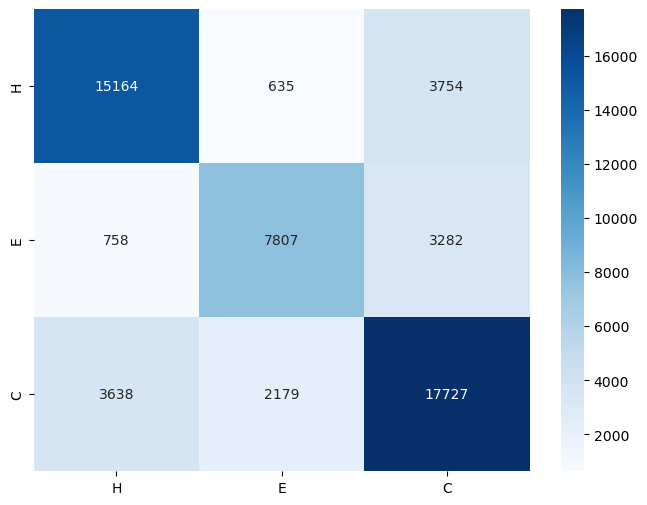

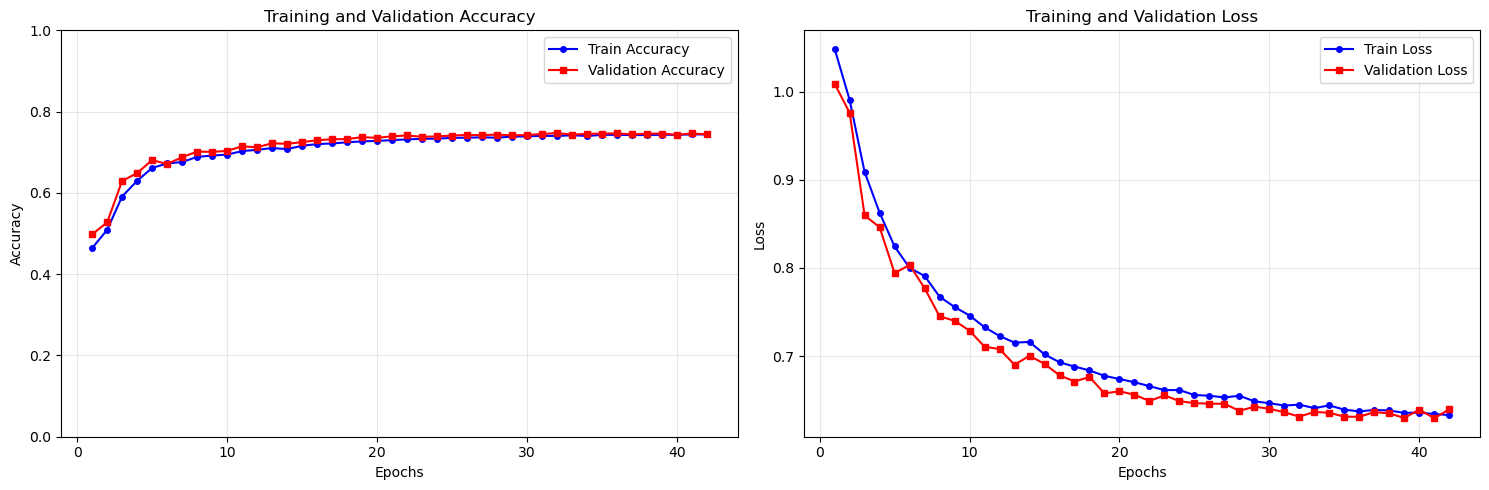

Evaluating on test set: 100%|██████████| 9/9 [00:00<00:00, 26.09it/s]



Test Results:
  Test Loss:     0.0325
  Test Accuracy: 0.7407 (74.07%)

Detailed Classification Report:
              precision    recall  f1-score   support

           H       0.78      0.78      0.78     19553
           E       0.74      0.66      0.69     11847
           C       0.72      0.75      0.73     23544

    accuracy                           0.74     54944
   macro avg       0.74      0.73      0.73     54944
weighted avg       0.74      0.74      0.74     54944



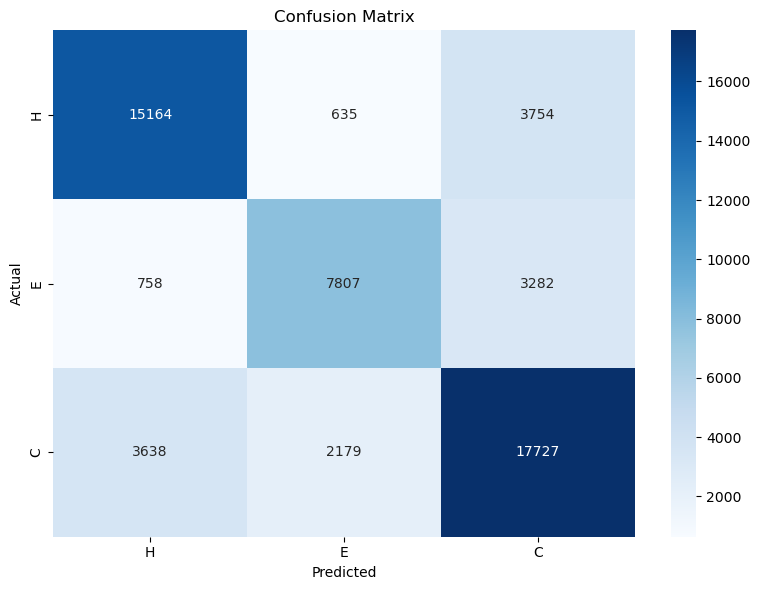


Per-Class Performance:
  H: Precision=0.775, Recall=0.776, F1=0.775
  E: Precision=0.735, Recall=0.659, F1=0.695
  C: Precision=0.716, Recall=0.753, F1=0.734
Classification_report : 
              precision    recall  f1-score   support

           H       0.78      0.78      0.78     19553
           E       0.74      0.66      0.69     11847
           C       0.72      0.75      0.73     23544

    accuracy                           0.74     54944
   macro avg       0.74      0.73      0.73     54944
weighted avg       0.74      0.74      0.74     54944



In [71]:
# Plot training results
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
# Evaluate the best model
results = evaluate_best_model(
    model_class=RNN_unidir_model,
    model_path="saved_models/best_rnn_model.pth", 
    test_gen=test_gen,
    criterion=criterion,
    device=device,
    target_names=target_names
)
results_dir["RNN_unidir"] = results

## RNN_Bidirectional Model

Training the model

In [72]:
rnn_bi_model = RNN_bidirec_model().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(rnn_bi_model.parameters(),lr=0.001)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    rnn_bi_model, train_gen, val_gen, optimizer, criterion, num_epochs=EPOCHS,
    patience=PATIENCE, min_delta=MIN_DELTA, save_best_model=True, model_save_path="saved_models/best_rnn_bi_model.pth"
)

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 42.51it/s]


Epoch : 0, Train_loss : 1.0259205618325402, Train_acc : 0.48449737387686576, Val_acc : 0.573685705013792


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 46.44it/s]


Epoch : 1, Train_loss : 0.8293345279553357, Train_acc : 0.6428446249910185, Val_acc : 0.7344840175239331


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 37.31it/s]


Epoch : 2, Train_loss : 0.6528323201572194, Train_acc : 0.7537753258337963, Val_acc : 0.7821677754340418


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 48.35it/s]


Epoch : 3, Train_loss : 0.5952443652293261, Train_acc : 0.7756018527443294, Val_acc : 0.7959394775271783


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 43.95it/s]


Epoch : 4, Train_loss : 0.5669763761408189, Train_acc : 0.7860441314866643, Val_acc : 0.8046405971117963


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 45.81it/s]


Epoch : 5, Train_loss : 0.5394653343102511, Train_acc : 0.7957214434301356, Val_acc : 0.8076220996268051


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 47.34it/s]


Epoch : 6, Train_loss : 0.5209073310389238, Train_acc : 0.8023345069250087, Val_acc : 0.8163637838714911


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 41.30it/s]


Epoch : 7, Train_loss : 0.5104377893840566, Train_acc : 0.8062530997365991, Val_acc : 0.8215966250202823


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 46.87it/s]


Epoch : 8, Train_loss : 0.500088025191251, Train_acc : 0.8099710311542149, Val_acc : 0.8235234463735194


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 43.54it/s]


Epoch : 9, Train_loss : 0.4903394541319679, Train_acc : 0.8130729583798476, Val_acc : 0.8256530910270972


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 39.96it/s]


Epoch : 10, Train_loss : 0.4862906903028488, Train_acc : 0.8144390331100062, Val_acc : 0.8222862242414408


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 32.21it/s]


Epoch : 11, Train_loss : 0.4781951427459717, Train_acc : 0.8176066791327923, Val_acc : 0.8265049488885283


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 38.21it/s]


Epoch : 12, Train_loss : 0.47602079177604, Train_acc : 0.817912490602212, Val_acc : 0.826971442479312


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 37.21it/s]


Epoch : 13, Train_loss : 0.47228947667514576, Train_acc : 0.8190183188956438, Val_acc : 0.8277624533506409


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 40.52it/s]


Epoch : 14, Train_loss : 0.4690413485555088, Train_acc : 0.8205228412251386, Val_acc : 0.8302571799448321


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 45.30it/s]


Epoch : 15, Train_loss : 0.4644710172625149, Train_acc : 0.822384873811147, Val_acc : 0.8289793931526854


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 36.65it/s]


Epoch : 16, Train_loss : 0.462635156862876, Train_acc : 0.8231384493518374, Val_acc : 0.8307236735356158


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 46.12it/s]


Epoch : 17, Train_loss : 0.45972492554608513, Train_acc : 0.8239568674390524, Val_acc : 0.8327316242089892


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 46.70it/s]


Epoch : 18, Train_loss : 0.45765430804561164, Train_acc : 0.8243730864876896, Val_acc : 0.8320420249878306


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 36.36it/s]


Epoch : 19, Train_loss : 0.45445669310934406, Train_acc : 0.8254289684952849, Val_acc : 0.831332143436638


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 44.94it/s]


Epoch : 20, Train_loss : 0.45318626340697793, Train_acc : 0.826277179103876, Val_acc : 0.8333400941100113


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 45.09it/s]


Epoch : 21, Train_loss : 0.45212765546406014, Train_acc : 0.826606649340271, Val_acc : 0.833786305370761


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 41.97it/s]


Epoch : 22, Train_loss : 0.4490478522637311, Train_acc : 0.8275039299840697, Val_acc : 0.8345570339120558


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 47.59it/s]


Epoch : 23, Train_loss : 0.44710343743071834, Train_acc : 0.8284073443822696, Val_acc : 0.8362810319649522


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 44.66it/s]


Epoch : 24, Train_loss : 0.44541161025271697, Train_acc : 0.828868252212971, Val_acc : 0.8346787278922603


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 37.21it/s]


Epoch : 25, Train_loss : 0.44472064919331494, Train_acc : 0.8293615813169346, Val_acc : 0.8359159500243388


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 38.44it/s]


Epoch : 26, Train_loss : 0.44177707573946784, Train_acc : 0.8302974169883967, Val_acc : 0.8342933636216129


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 41.90it/s]


Epoch : 27, Train_loss : 0.4399839220678105, Train_acc : 0.8305778171895838, Val_acc : 0.837072042836281


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 41.77it/s]


Epoch : 28, Train_loss : 0.43973843823460973, Train_acc : 0.8307556960672119, Val_acc : 0.8358551030342366


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 44.14it/s]


Epoch : 29, Train_loss : 0.43819160671795115, Train_acc : 0.8317081805006195, Val_acc : 0.835429174103521


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 46.24it/s]


Epoch : 30, Train_loss : 0.43791772162213044, Train_acc : 0.8316214316883772, Val_acc : 0.8349423981827032


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 40.37it/s]


Epoch : 31, Train_loss : 0.4354380735579659, Train_acc : 0.8323320709482609, Val_acc : 0.8360376440045433


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 42.16it/s]


Epoch : 32, Train_loss : 0.4343295626780566, Train_acc : 0.832941941385843, Val_acc : 0.8387960408891774


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 45.68it/s]


Epoch : 33, Train_loss : 0.4339809235404519, Train_acc : 0.833401096715287, Val_acc : 0.839810157390881


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 44.28it/s]


Epoch : 34, Train_loss : 0.43391379223150367, Train_acc : 0.8328744700874323, Val_acc : 0.8388974525393477


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 43.35it/s]


Epoch : 35, Train_loss : 0.4319149103234796, Train_acc : 0.8335588218284546, Val_acc : 0.8395464871004381


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 36.89it/s]


Epoch : 36, Train_loss : 0.43064368980772355, Train_acc : 0.834074057198136, Val_acc : 0.8391611228297907


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 46.43it/s]


Epoch : 37, Train_loss : 0.4286829932647593, Train_acc : 0.8349064952954104, Val_acc : 0.840337497971767


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 38.28it/s]


Epoch : 38, Train_loss : 0.428586322945707, Train_acc : 0.8347785627036187, Val_acc : 0.8416152847639137


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 45.58it/s]


Epoch : 39, Train_loss : 0.42853713386199055, Train_acc : 0.8349573178318755, Val_acc : 0.8397290280707448


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 42.02it/s]


Epoch : 40, Train_loss : 0.42915821408524235, Train_acc : 0.8345822825627878, Val_acc : 0.8413718968035048


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 43.43it/s]


Epoch : 41, Train_loss : 0.4264562841723947, Train_acc : 0.8353446206097653, Val_acc : 0.8392219698198929


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 44.02it/s]


Epoch : 42, Train_loss : 0.4273052110391505, Train_acc : 0.8352236980230033, Val_acc : 0.8389380171994159


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 44.76it/s]


Epoch : 43, Train_loss : 0.4243119462448008, Train_acc : 0.8364469439006822, Val_acc : 0.8418383903942885


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 46.39it/s]


Epoch : 44, Train_loss : 0.42390410637154297, Train_acc : 0.8363698338453558, Val_acc : 0.8417572610741522


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 48.42it/s]


Epoch : 45, Train_loss : 0.4225812910234227, Train_acc : 0.8368316179266858, Val_acc : 0.841453026123641


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 44.58it/s]


Epoch : 46, Train_loss : 0.4234538179986617, Train_acc : 0.8369595505184775, Val_acc : 0.8417166964140841


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 41.45it/s]


Epoch : 47, Train_loss : 0.4212093051742105, Train_acc : 0.8372487132259517, Val_acc : 0.8403172156417329


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 43.83it/s]


 Early stopping triggered after 49 epochs!
Best model was at epoch 39 with validation accuracy: 0.8416


Plotting graph and evaluating results

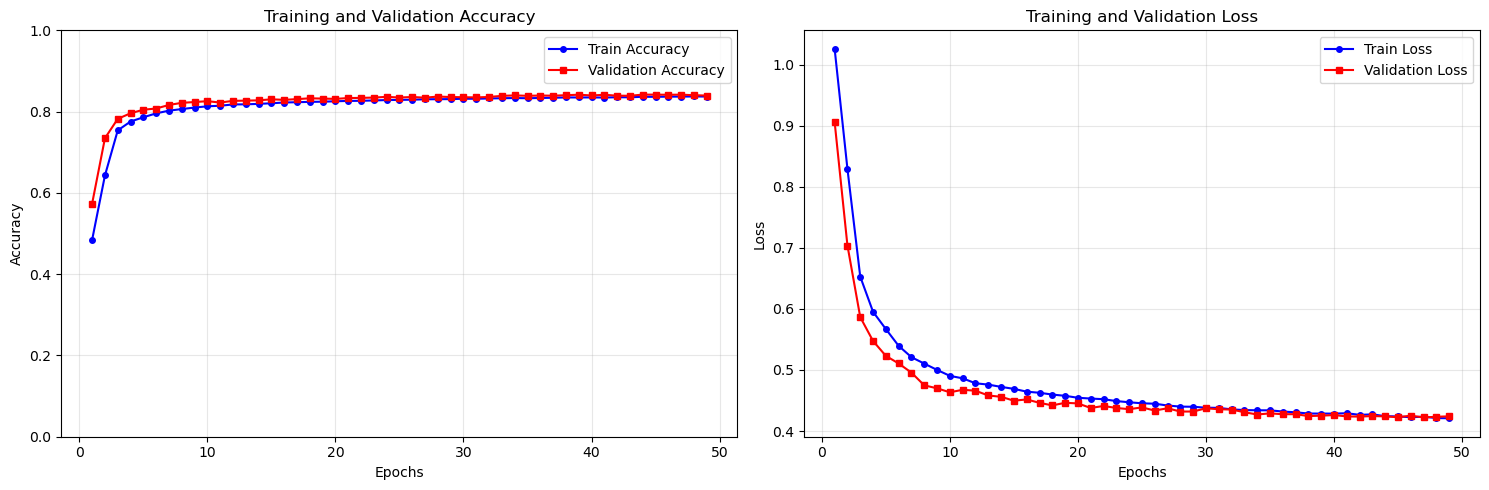

Evaluating on test set: 100%|██████████| 9/9 [00:00<00:00, 41.39it/s]



Test Results:
  Test Loss:     0.0213
  Test Accuracy: 0.8338 (83.38%)

Detailed Classification Report:
              precision    recall  f1-score   support

           H       0.88      0.90      0.89     19553
           E       0.80      0.75      0.78     11847
           C       0.81      0.82      0.82     23544

    accuracy                           0.83     54944
   macro avg       0.83      0.82      0.83     54944
weighted avg       0.83      0.83      0.83     54944



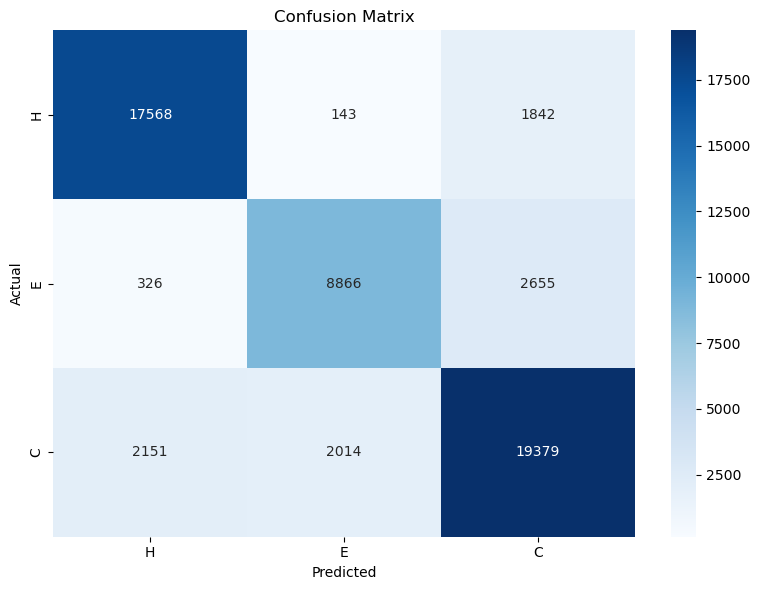


Per-Class Performance:
  H: Precision=0.876, Recall=0.898, F1=0.887
  E: Precision=0.804, Recall=0.748, F1=0.775
  C: Precision=0.812, Recall=0.823, F1=0.817
Classification_report : 
              precision    recall  f1-score   support

           H       0.88      0.90      0.89     19553
           E       0.80      0.75      0.78     11847
           C       0.81      0.82      0.82     23544

    accuracy                           0.83     54944
   macro avg       0.83      0.82      0.83     54944
weighted avg       0.83      0.83      0.83     54944



In [73]:
# Plot training results
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
# Evaluate the best model
results = evaluate_best_model(
    model_class=RNN_bidirec_model,
    model_path="saved_models/best_rnn_bi_model.pth", 
    test_gen=test_gen,
    criterion=criterion,
    device=device,
    target_names=target_names
)
results_dir["RNN_bidirec"] = results

## GRU Bidirectional Model

Training the model

In [74]:
gru_model = GRU_bidirec_model().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(gru_model.parameters(),lr=0.001)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    gru_model, train_gen, val_gen, optimizer, criterion, num_epochs=EPOCHS,
    patience=PATIENCE, min_delta=MIN_DELTA, save_best_model=True, model_save_path="saved_models/best_gru_model.pth"
)

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.33it/s]


Epoch : 0, Train_loss : 0.7721497714519501, Train_acc : 0.6975489517413729, Val_acc : 0.7773608632159662


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.69it/s]


Epoch : 1, Train_loss : 0.5952764647848466, Train_acc : 0.778701151218076, Val_acc : 0.7933027746227487


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.94it/s]


Epoch : 2, Train_loss : 0.549425080243279, Train_acc : 0.7952062080604543, Val_acc : 0.8061617718643518


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.40it/s]


Epoch : 3, Train_loss : 0.5156624131342944, Train_acc : 0.8066675662839788, Val_acc : 0.8176618529936719


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 23.93it/s]


Epoch : 4, Train_loss : 0.4826639538302141, Train_acc : 0.8181201620012163, Val_acc : 0.824780950835632


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.21it/s]


Epoch : 5, Train_loss : 0.46262061525793635, Train_acc : 0.8241067062965618, Val_acc : 0.8300949213045594


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.19it/s]


Epoch : 6, Train_loss : 0.4455476811703514, Train_acc : 0.8290697898575742, Val_acc : 0.8351046568229759


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.88it/s]


Epoch : 7, Train_loss : 0.4311758756637573, Train_acc : 0.8337095369365928, Val_acc : 0.8366258315755314


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.21it/s]


Epoch : 8, Train_loss : 0.42283837672542124, Train_acc : 0.8364828701764594, Val_acc : 0.8388974525393477


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.76it/s]


Epoch : 9, Train_loss : 0.4165365285733167, Train_acc : 0.838709423024011, Val_acc : 0.8376805127373033


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 24.46it/s]


Epoch : 10, Train_loss : 0.4098279868855196, Train_acc : 0.8409280896159043, Val_acc : 0.8418789550543566


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.14it/s]


Epoch : 11, Train_loss : 0.4042386054992676, Train_acc : 0.842855840999066, Val_acc : 0.843623235437287


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.19it/s]


Epoch : 12, Train_loss : 0.39693421633804543, Train_acc : 0.8457308193118629, Val_acc : 0.8451849748499107


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.39it/s]


Epoch : 13, Train_loss : 0.39270742395344904, Train_acc : 0.8470101452297792, Val_acc : 0.8460976797014441


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.04it/s]


Epoch : 14, Train_loss : 0.38882854388040655, Train_acc : 0.8482807086414085, Val_acc : 0.843623235437287


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.28it/s]


Epoch : 15, Train_loss : 0.3843236425343682, Train_acc : 0.8500016648761946, Val_acc : 0.8443128346584455


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.92it/s]


Epoch : 16, Train_loss : 0.3795914614901823, Train_acc : 0.8520713688612072, Val_acc : 0.8467061496024664


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 23.47it/s]


Epoch : 17, Train_loss : 0.3758617309963002, Train_acc : 0.8532902334857425, Val_acc : 0.8483490183352264


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.65it/s]


Epoch : 18, Train_loss : 0.37091019679518306, Train_acc : 0.8551531423223796, Val_acc : 0.8487546649359078


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.17it/s]


Epoch : 19, Train_loss : 0.366471510774949, Train_acc : 0.8565884408522063, Val_acc : 0.8491197468765211


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.48it/s]


Epoch : 20, Train_loss : 0.3641495895736358, Train_acc : 0.8569801248832396, Val_acc : 0.8502149926983612


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.18it/s]


Epoch : 21, Train_loss : 0.3591115430873983, Train_acc : 0.8587895824315254, Val_acc : 0.8496876521174752


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.00it/s]


Epoch : 22, Train_loss : 0.3561875653617522, Train_acc : 0.8602424059739263, Val_acc : 0.8480447833847152


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.55it/s]


Epoch : 23, Train_loss : 0.3537444070858114, Train_acc : 0.8609819615045574, Val_acc : 0.8503164043485315


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.10it/s]


Epoch : 24, Train_loss : 0.3499453099334941, Train_acc : 0.8622691736781322, Val_acc : 0.8502961220184975


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.89it/s]


Epoch : 25, Train_loss : 0.3459772113491507, Train_acc : 0.8633890219816233, Val_acc : 0.8480650657147493


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.27it/s]


Epoch : 26, Train_loss : 0.34330673971596887, Train_acc : 0.8646332978743912, Val_acc : 0.8510668505597923


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 23.44it/s]


Epoch : 27, Train_loss : 0.34019497054464676, Train_acc : 0.8659213862985947, Val_acc : 0.8487546649359078


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.06it/s]


Epoch : 28, Train_loss : 0.336264905333519, Train_acc : 0.867152518431932, Val_acc : 0.8498093460976797


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.58it/s]


Epoch : 29, Train_loss : 0.3355870693922043, Train_acc : 0.8676677538016133, Val_acc : 0.8511682622099627


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.02it/s]


 Early stopping triggered after 31 epochs!
Best model was at epoch 21 with validation accuracy: 0.8502


Plotting and Evaluating results

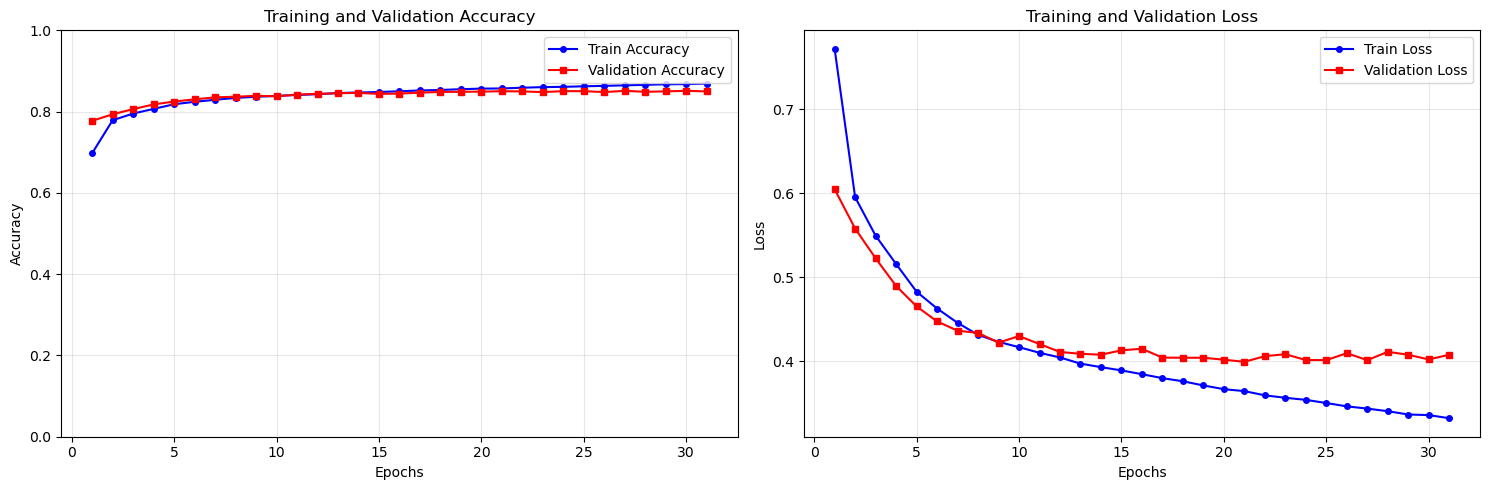

Evaluating on test set: 100%|██████████| 9/9 [00:00<00:00, 24.05it/s]



Test Results:
  Test Loss:     0.0197
  Test Accuracy: 0.8434 (84.34%)

Detailed Classification Report:
              precision    recall  f1-score   support

           H       0.89      0.90      0.89     19553
           E       0.82      0.76      0.79     11847
           C       0.82      0.84      0.83     23544

    accuracy                           0.84     54944
   macro avg       0.84      0.83      0.84     54944
weighted avg       0.84      0.84      0.84     54944



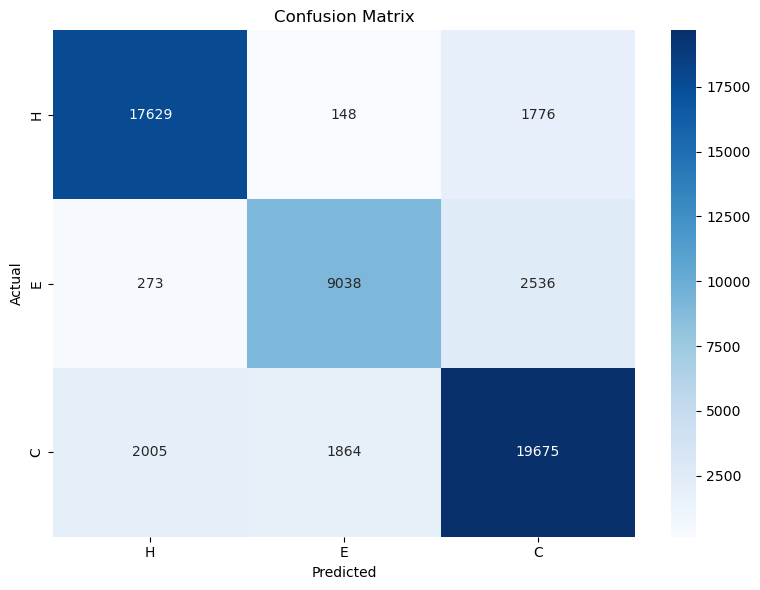


Per-Class Performance:
  H: Precision=0.886, Recall=0.902, F1=0.894
  E: Precision=0.818, Recall=0.763, F1=0.789
  C: Precision=0.820, Recall=0.836, F1=0.828
Classification_report : 
              precision    recall  f1-score   support

           H       0.89      0.90      0.89     19553
           E       0.82      0.76      0.79     11847
           C       0.82      0.84      0.83     23544

    accuracy                           0.84     54944
   macro avg       0.84      0.83      0.84     54944
weighted avg       0.84      0.84      0.84     54944



In [75]:
# Plot training results
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
# Evaluate the best model
results = evaluate_best_model(
    model_class=GRU_bidirec_model,
    model_path="saved_models/best_gru_model.pth", 
    test_gen=test_gen,
    criterion=criterion,
    device=device,
    target_names=target_names
)
results_dir["GRU_bidirec"] = results

## Comparing Results

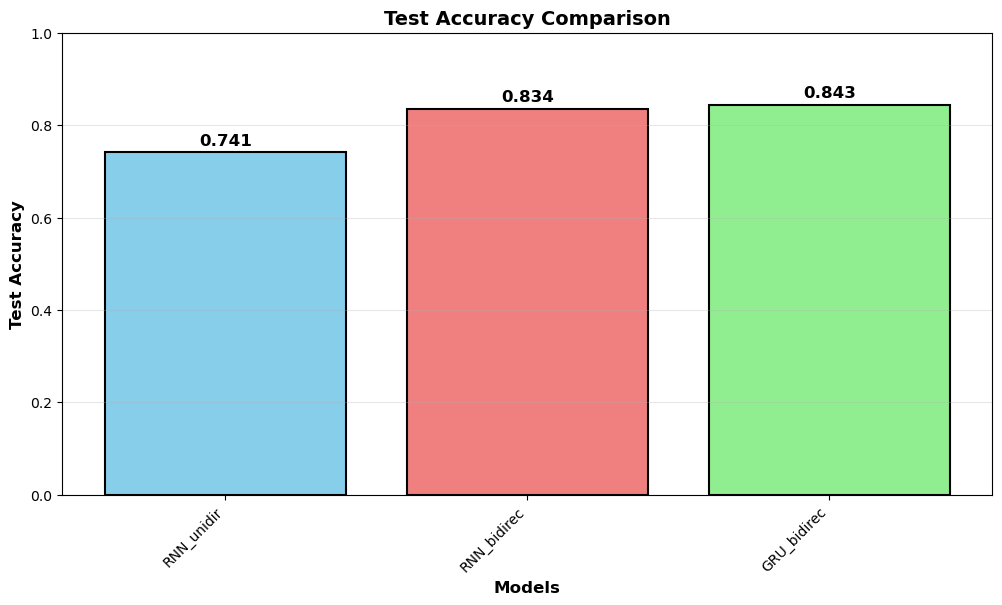

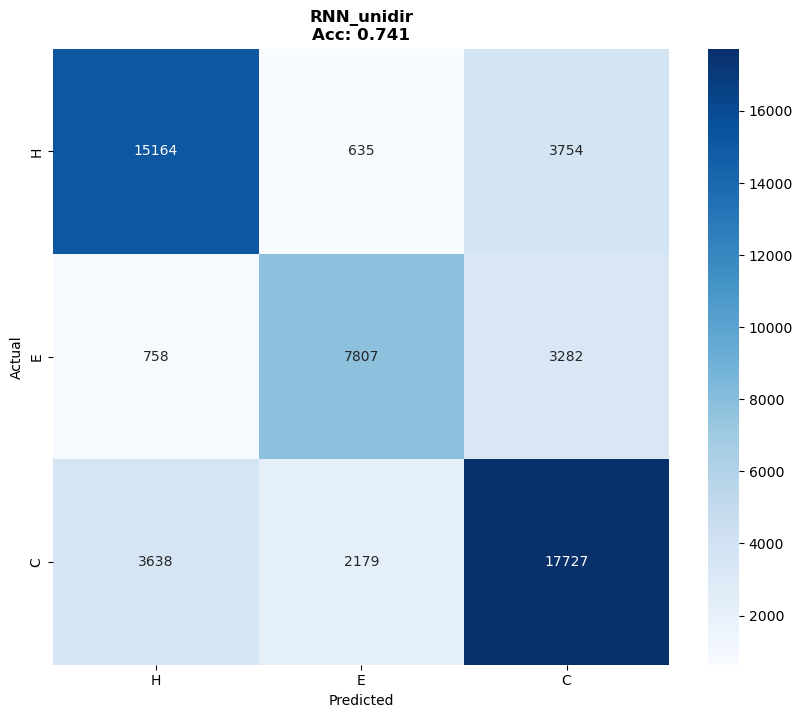

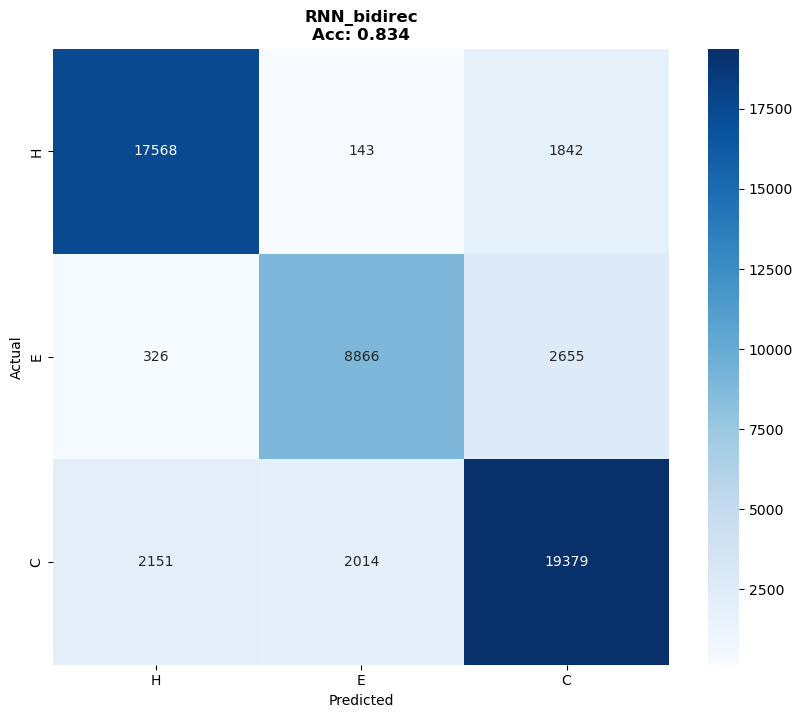

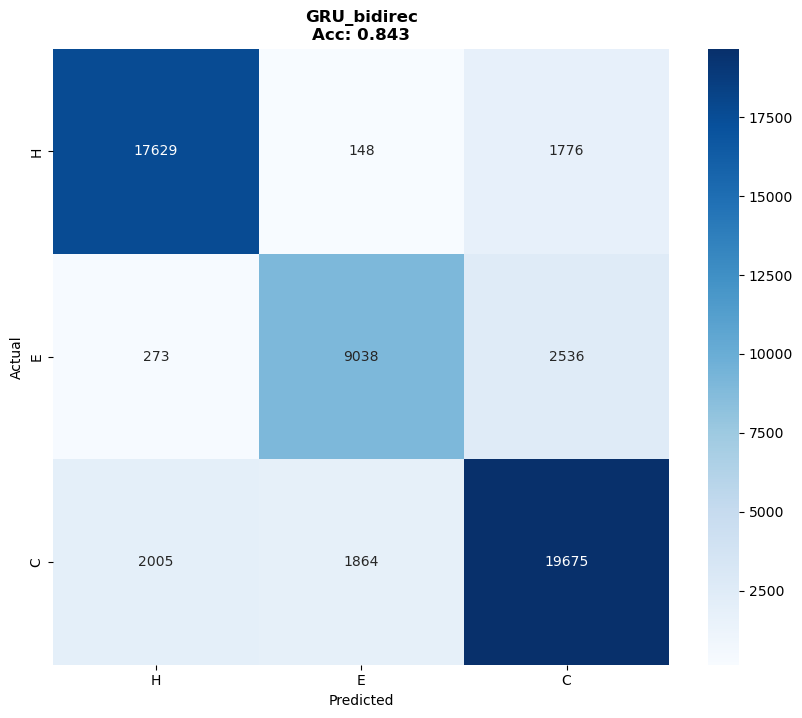

In [85]:
model_names = list(results_dir.keys())
num_models = len(model_names)

# Extract test accuracies
test_accuracies = [results_dir[model]['test_accuracy'] for model in model_names]

# Create figure with subplots


# 1. Test Accuracy Comparison Bar Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(num_models), test_accuracies, 
                color=['skyblue', 'lightcoral', 'lightgreen'][:num_models],
                edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, test_accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=12, fontweight='bold')
plt.title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xticks(range(num_models), model_names, rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2. Confusion Matrices for each model
for i, model_name in enumerate(model_names):
    cm = results_dir[model_name]['confusion_matrix']
    test_acc = results_dir[model_name]['test_accuracy']
    
    # Raw confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar=True, square=True)
    plt.title(f'{model_name}\nAcc: {test_acc:.3f}', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)
    plt.show()


# Q8 Task

From our previous results, we can see that the bidirectional GRU had the best performance.

However,in previous section we just used q3 labels('H','E','C'),however dataset also contains q8 labels.(8 different types of secondary structure).

Lets see how well our model performs on Q8 secondary structure prediction task.

First, lets see distribution of labels in Q8 task .

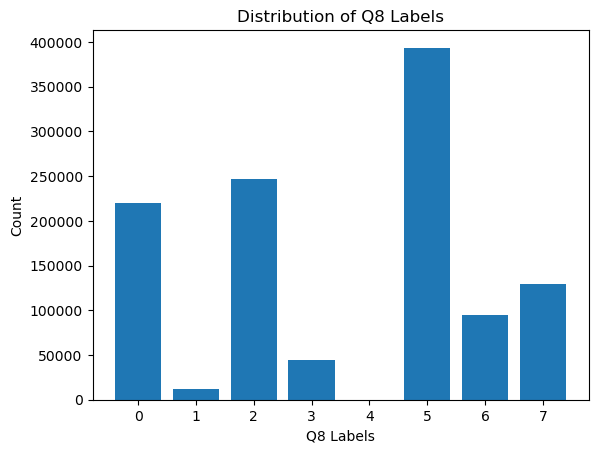

In [77]:
q8_label_count =[0] * 8
for i in var:
    for j in var[i]["secstr"]:
        if j < 8:
            q8_label_count[j] += 1
plt.bar(range(8), q8_label_count, tick_label=range(8))
plt.xlabel('Q8 Labels')
plt.ylabel('Count')
plt.title('Distribution of Q8 Labels')
plt.show()

We have very little data on 1,4,6,7 so model will probably struggle with those labels. Lets see if our hypothesis is true.

### Training the model

In [99]:
gru_model = GRU_bidirec_model(output_dim=8).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(gru_model.parameters(),lr=0.001)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    gru_model, train_gen, val_gen, optimizer, criterion, num_epochs=EPOCHS,
    patience=PATIENCE, min_delta=MIN_DELTA, save_best_model=True, model_save_path="saved_models/best_gru_model_q8.pth",task="Q8"
)

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.12it/s]


Epoch : 0, Train_loss : 1.2760368157835569, Train_acc : 0.5538254473697585, Val_acc : 0.634005354535129


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.09it/s]


Epoch : 1, Train_loss : 1.060623485551161, Train_acc : 0.6330341229519832, Val_acc : 0.6548758721401915


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.27it/s]


Epoch : 2, Train_loss : 0.979671466701171, Train_acc : 0.6564808372750007, Val_acc : 0.6686070095732598


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.95it/s]


Epoch : 3, Train_loss : 0.9279049249256358, Train_acc : 0.6713324091810036, Val_acc : 0.6811212072042836


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 29.31it/s]


Epoch : 4, Train_loss : 0.8890778481960296, Train_acc : 0.682323220816911, Val_acc : 0.6889907512575044


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.00it/s]


Epoch : 5, Train_loss : 0.8654686412390541, Train_acc : 0.6891229256956992, Val_acc : 0.694608956676943


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.76it/s]


Epoch : 6, Train_loss : 0.849328296324786, Train_acc : 0.6942376006154785, Val_acc : 0.6985437287035534


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.21it/s]


Epoch : 7, Train_loss : 0.8361526170197655, Train_acc : 0.6982744872619446, Val_acc : 0.7022959597598573


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.81it/s]


Epoch : 8, Train_loss : 0.8253851936143988, Train_acc : 0.701719028483403, Val_acc : 0.6994564335550868


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.14it/s]


Epoch : 9, Train_loss : 0.8153372224639444, Train_acc : 0.7050601721306735, Val_acc : 0.707691059548921


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.47it/s]


Epoch : 10, Train_loss : 0.8071926365880405, Train_acc : 0.7077318602976098, Val_acc : 0.7091311049813402


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.22it/s]


Epoch : 11, Train_loss : 0.7989812048042522, Train_acc : 0.7103544784293383, Val_acc : 0.7110376440045433


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.33it/s]


Epoch : 12, Train_loss : 0.7918077837018406, Train_acc : 0.7124127911561776, Val_acc : 0.7128022067175077


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.32it/s]


Epoch : 13, Train_loss : 0.7852638395393596, Train_acc : 0.7148329953926742, Val_acc : 0.7141002758396885


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.29it/s]


Epoch : 14, Train_loss : 0.7797456958714654, Train_acc : 0.7165925066551235, Val_acc : 0.7144247931202337


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


Epoch : 15, Train_loss : 0.7742808503263137, Train_acc : 0.7184142317122113, Val_acc : 0.7128224890475418


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.83it/s]


Epoch : 16, Train_loss : 0.7698705080677481, Train_acc : 0.7203121905739968, Val_acc : 0.714810157390881


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.27it/s]


Epoch : 17, Train_loss : 0.7650006785112269, Train_acc : 0.7215310551985321, Val_acc : 0.7161893558331981


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.50it/s]


Epoch : 18, Train_loss : 0.7601605874650619, Train_acc : 0.723322111483615, Val_acc : 0.7171629076748337


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.22it/s]


Epoch : 19, Train_loss : 0.7556388244909399, Train_acc : 0.724662774945541, Val_acc : 0.7187043647574234


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.17it/s]


Epoch : 20, Train_loss : 0.7515072173932019, Train_acc : 0.7263127548794016, Val_acc : 0.7174062956352426


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 30.36it/s]


Epoch : 21, Train_loss : 0.7478662343586192, Train_acc : 0.7271819955030818, Val_acc : 0.7159459678727892


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.00it/s]


Epoch : 22, Train_loss : 0.7425321736756493, Train_acc : 0.7289143429960411, Val_acc : 0.7161285088430959


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.63it/s]


Epoch : 23, Train_loss : 0.7396789561299717, Train_acc : 0.7303435077714668, Val_acc : 0.719170858348207


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.37it/s]


Epoch : 24, Train_loss : 0.7356073067468756, Train_acc : 0.7317709200456352, Val_acc : 0.7179742008761967


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.16it/s]


Epoch : 25, Train_loss : 0.7318252703722785, Train_acc : 0.7328452033164333, Val_acc : 0.7168383903942885


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.75it/s]


Epoch : 26, Train_loss : 0.7282827720922582, Train_acc : 0.7338861890633407, Val_acc : 0.718075612526367


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.17it/s]


Epoch : 27, Train_loss : 0.7252011008122388, Train_acc : 0.7346134770851698, Val_acc : 0.7165950024338796


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.85it/s]


Epoch : 28, Train_loss : 0.7221328304094426, Train_acc : 0.7361162469134072, Val_acc : 0.7165950024338796


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.60it/s]



 Early stopping triggered after 30 epochs!
Best model was at epoch 20 with validation accuracy: 0.7187


## Plotting and evaluating model

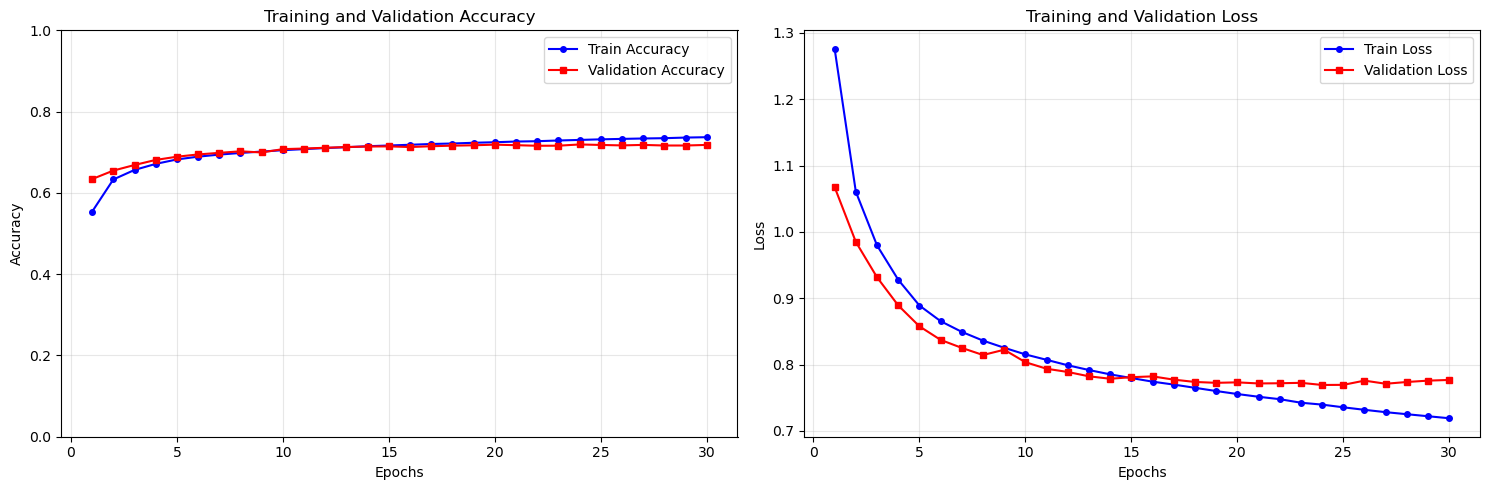

Evaluating on test set: 100%|██████████| 9/9 [00:00<00:00, 17.13it/s]



Test Results:
  Test Loss:     0.0388
  Test Accuracy: 0.7167 (71.67%)


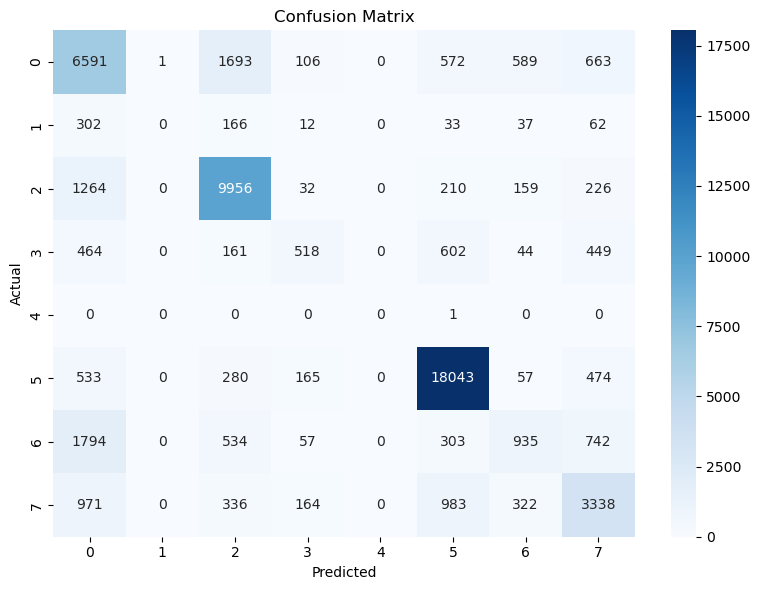


Per-Class Performance:
  0: Precision=0.553, Recall=0.645, F1=0.596
  1: Precision=0.000, Recall=0.000, F1=0.000
  2: Precision=0.758, Recall=0.840, F1=0.797
  3: Precision=0.491, Recall=0.231, F1=0.315
  4: Precision=0.000, Recall=0.000, F1=0.000
  5: Precision=0.870, Recall=0.923, F1=0.895
  6: Precision=0.436, Recall=0.214, F1=0.287
  7: Precision=0.561, Recall=0.546, F1=0.553


In [105]:
# Plot training results
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
# Evaluate the best model
results = evaluate_best_model(
    model_class=GRU_bidirec_model,
    model_path="saved_models/best_gru_model_q8.pth", 
    test_gen=test_gen,
    criterion=criterion,
    device=device,
    task="Q8"
)
results_dir["GRU_bidirec"] = results

We got worse performance on Q8 as expected as we had very less data points for certain classes.
But, for 8 class classification, 71 % accuracy is decent.